<a href="https://colab.research.google.com/github/Yash-Jumde/Colab-Notebooks/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


# Getting the data

In [ ]:
import pandas as pd

df = pd.read_csv("/content/BTC-USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3559 entries, 2014-09-17 to 2024-06-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3559 non-null   float64
 1   High       3559 non-null   float64
 2   Low        3559 non-null   float64
 3   Close      3559 non-null   float64
 4   Adj Close  3559 non-null   float64
 5   Volume     3559 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 194.6 KB


In [ ]:
len(df)

3559

In [ ]:
bitcoin_prices = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})

In [ ]:
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [ ]:
bitcoin_prices.tail()

,Price
Date,
2024-06-10,69512.281250
2024-06-11,67332.031250
2024-06-12,68241.187500
2024-06-13,66756.398438
2024-06-14,66703.804688


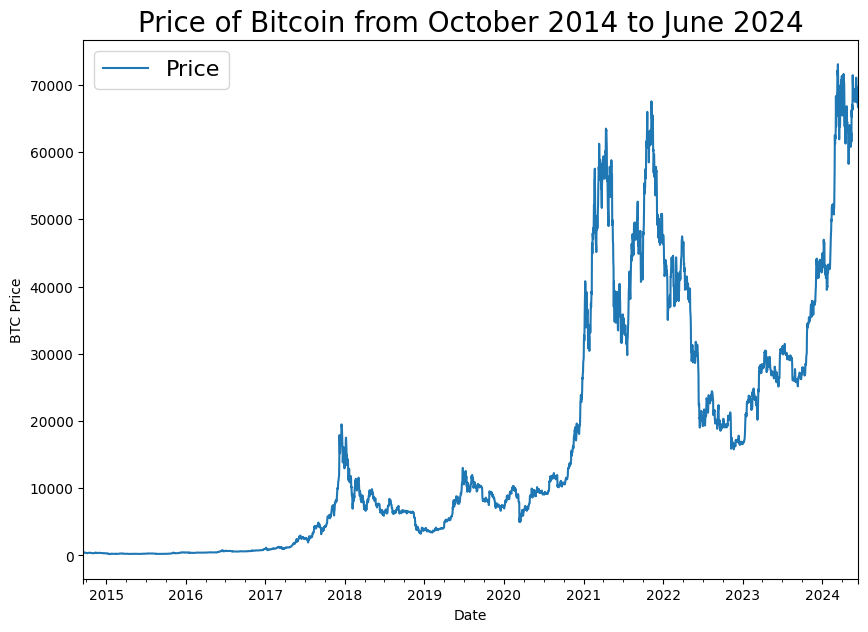

In [ ]:
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from October 2014 to June 2024", fontsize=20)
plt.legend(fontsize=16)

Formating data

In [ ]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

In [ ]:
# Let's have a 80% train and 20% test data
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2847, 712, 2847, 712)

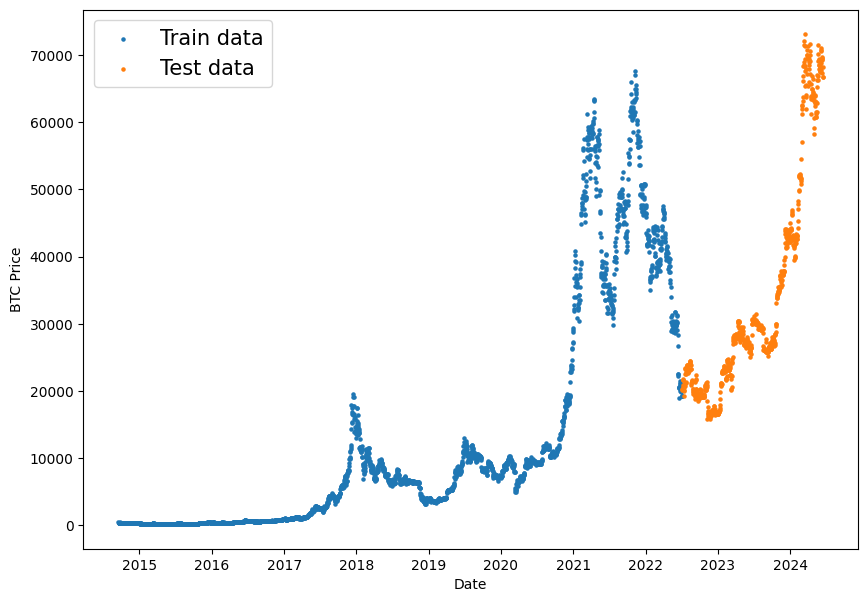

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=15)
plt.show()

In [ ]:
# Function for plotting a time series

def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Price")
  if label:
    plt.legend(fontsize=15)
  plt.grid(True)

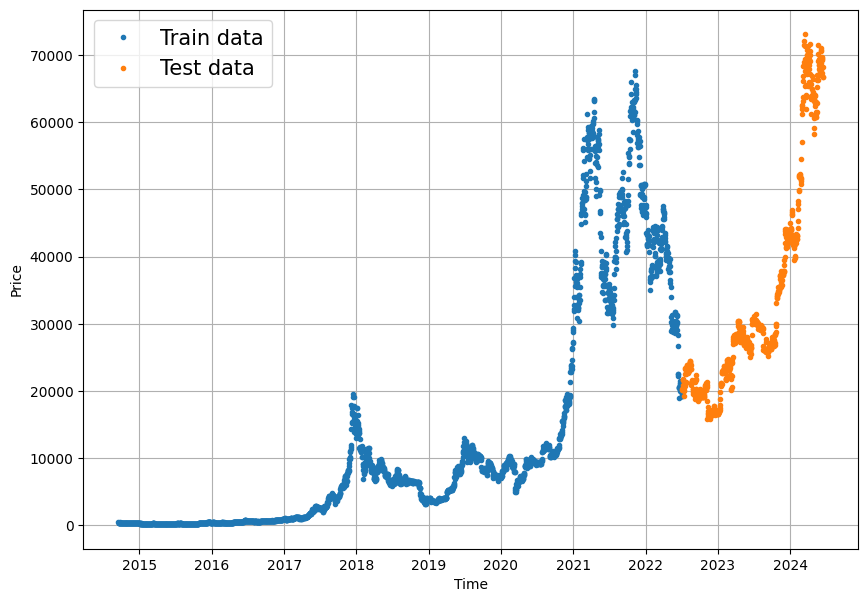

In [ ]:
# Trying out the above function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

Naive Forecast

In [ ]:
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([20231.261719, 20190.115234, 20548.246094, 21637.587891,
        21731.117188, 21592.207031, 20860.449219, 19970.556641,
        19323.914063, 20212.074219]),
 array([70567.765625, 71082.820313, 70757.164063, 69342.585938,
        69305.773438, 69647.992188, 69512.28125 , 67332.03125 ,
        68241.1875  , 66756.398438]))

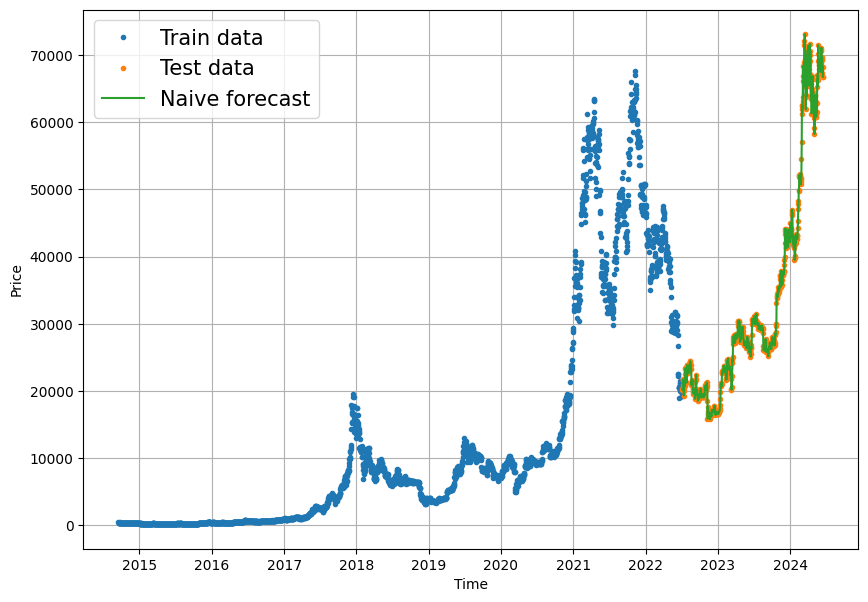

In [ ]:
# Plotting naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast")

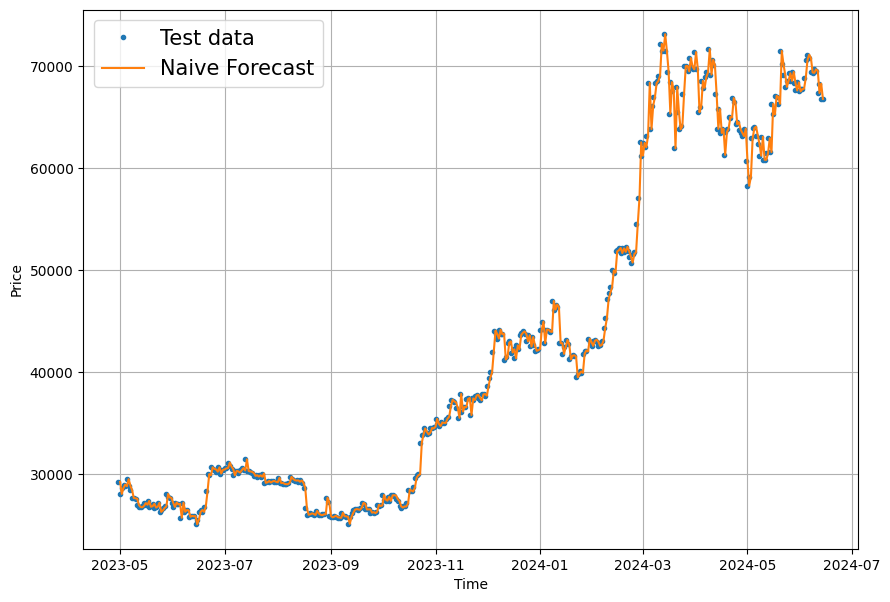

In [ ]:
# Zooming in
plt.figure(figsize=(10,7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:],
                 values=naive_forecast,
                 format="-",
                 start=offset,
                 label="Naive Forecast")

In [ ]:
import tensorflow as tf

# Using Mean absolute squared error assuming no seasonality of data
def MASE(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive

In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = MASE(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 618.52423,
 'mse': 1057173.9,
 'rmse': 1028.1896,
 'mape': 1.7543935,
 'mase': 0.9986869}

In [ ]:
# Average price of bitcoin in the test data
tf.reduce_mean(y_test).numpy()

33613.254279408706

Windowing the dataset.

In [ ]:
# Size has been decided randomly
HORIZON_1 = 1
WINDOW_SIZE_1 = 7

In [ ]:
# Function to get labelled windows
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON_1)
print(f"Window: {tf.squeeze(test_window).numpy()}")
print(f"label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7]
label: 8


In [ ]:
# Function for NumPy arrays to be viewed as windows.
import numpy as np

def make_windows(x, window_size=7, horizon=1):
  # Creating a window of "window_size"
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # num_windows = len(x) - window_size - horizon + 1

  # Creating a 2D array of multiple window steps
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  # window_indexes = np.expand_dims(np.arange(window_size + horizon), axis=0) + np.expand_dims(np.arange(num_windows), axis=0).T

  # Index on the target array
  windowed_array = x[window_indexes]

  # Gete labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows_1, full_labels_1 = make_windows(prices, window_size=WINDOW_SIZE_1, horizon=HORIZON_1)
len(full_windows_1), len(full_labels_1)

(3552, 3552)

In [ ]:
# First 5 windows & labels
for i in range(5):
  print(f"Window: {full_windows_1[i]}\n Label: {full_labels_1[i]}")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985]
 Label: [423.204987]
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987]
 Label: [411.574005]
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005]
 Label: [404.424988]
Window: [408.903992 398.821014 402.152008 435.790985 423.204987 411.574005
 404.424988]
 Label: [399.519989]
Window: [398.821014 402.152008 435.790985 423.204987 411.574005 404.424988
 399.519989]
 Label: [377.181]


In [ ]:
# Last 5 windows
for i in range(5):
  print(f"Window: {full_windows_1[i-5]}\n Label: {full_labels_1[i-5]}")

Window: [68804.78125  70567.765625 71082.820313 70757.164063 69342.585938
 69305.773438 69647.992188]
 Label: [69512.28125]
Window: [70567.765625 71082.820313 70757.164063 69342.585938 69305.773438
 69647.992188 69512.28125 ]
 Label: [67332.03125]
Window: [71082.820313 70757.164063 69342.585938 69305.773438 69647.992188
 69512.28125  67332.03125 ]
 Label: [68241.1875]
Window: [70757.164063 69342.585938 69305.773438 69647.992188 69512.28125
 67332.03125  68241.1875  ]
 Label: [66756.398438]
Window: [69342.585938 69305.773438 69647.992188 69512.28125  67332.03125
 68241.1875   66756.398438]
 Label: [66703.804688]


Preparing the training and testing datasets.

In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
  # 80% train split 20% test split
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
# Testing the function
train_windows_1, test_windows_1, train_labels_1, test_labels_1 = make_train_test_splits(full_windows_1, full_labels_1)
len(train_windows_1), len(test_windows_1), len(train_labels_1), len(test_labels_1)

(2841, 711, 2841, 711)

Modelling Checkpoint.

In [ ]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

Dense Model where window = 7 and horizon = 1

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

In [ ]:
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON_1, activation="linear")
], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae"])

model_1.fit(x=train_windows_1,
            y=train_labels_1,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows_1, test_labels_1),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
23/23 [==============================] - 6s 161ms/step - loss: 4528.1909 - mae: 4528.1909 - val_loss: 4303.0688 - val_mae: 4303.0688
Epoch 2/100
23/23 [==============================] - 1s 50ms/step - loss: 918.5687 - mae: 918.5687 - val_loss: 1389.1498 - val_mae: 1389.1498
Epoch 3/100
23/23 [==============================] - 1s 37ms/step - loss: 702.6418 - mae: 702.6418 - val_loss: 1067.8323 - val_mae: 1067.8323
Epoch 4/100
23/23 [==============================] - 1s 31ms/step - loss: 625.3886 - mae: 625.3886 - val_loss: 1001.9891 - val_mae: 1001.9891
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 606.3713 - mae: 606.3713 - val_loss: 1010.4191 - val_mae: 1010.4191
Epoch 6/100
23/23 [==============================] - 0s 6ms/step - loss: 594.3587 - mae: 594.3587 - val_loss: 1221.0250 - val_mae: 1221.0250
Epoch 7/100
23/23 [==============================] - 1s 30ms/step - loss: 581.9788 - mae: 581.9788 - val_loss: 922.3984 - val_mae: 922.3984
Epoch 8

In [ ]:
model_1.evaluate(test_windows_1, test_labels_1)

23/23 [==============================] - 0s 3ms/step - loss: 660.2138 - mae: 660.2138


[660.2138061523438, 660.2138061523438]

In [ ]:
# Loading the saved best model_1
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows_1, test_labels_1)

23/23 [==============================] - 0s 2ms/step - loss: 614.7228 - mae: 614.7228


[614.7227783203125, 614.7227783203125]

Making forecasts on the test dataset.

In [ ]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
model_1_preds = make_preds(model_1, test_windows_1)
len(model_1_preds), model_1_preds[:10]

23/23 [==============================] - 0s 3ms/step


(711,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([20074.795, 20207.057, 20562.602, 21490.756, 21794.59 , 21707.086,
        21026.98 , 20152.646, 19393.592, 20005.27 ], dtype=float32)>)

In [ ]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels_1),
                                 y_pred=model_1_preds)

model_1_results

{'mae': 614.72266,
 'mse': 1038270.56,
 'rmse': 1018.9556,
 'mape': 1.7609261,
 'mase': 0.9925488}

In [ ]:
naive_results

{'mae': 618.52423,
 'mse': 1057173.9,
 'rmse': 1028.1896,
 'mape': 1.7543935,
 'mase': 0.9986869}

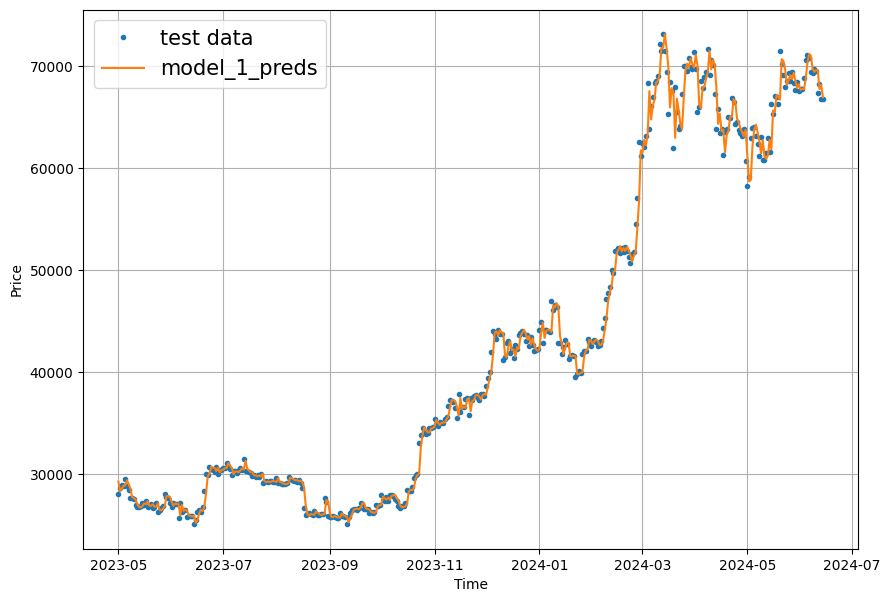

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows_1):],
                 values=test_labels_1[:, 0],
                 start=offset,
                 label="test data")

plot_time_series(timesteps=X_test[-len(test_windows_1):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="model_1_preds")

Dense model with window = 30 and horizon = 1

In [ ]:
HORIZON_2 = 1
WINDOW_SIZE_2 = 30

In [ ]:
full_windows_2, full_labels_2 = make_windows(prices,
                                         window_size=WINDOW_SIZE_2,
                                         horizon=HORIZON_2)

len(full_windows_2), len(full_labels_2)

(3529, 3529)

In [ ]:
train_windows_2, test_windows_2, train_labels_2, test_labels_2 = make_train_test_splits(windows=full_windows_2,
                                                                                labels=full_labels_2)
len(train_windows_2), len(test_windows_2), len(train_labels_2), len(test_labels_2)

(2823, 706, 2823, 706)

In [ ]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON_2),
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer="Adam")

model_2.fit(train_windows_2,
            train_labels_2,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows_2, test_labels_2),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
model_2.evaluate(test_windows_2, test_labels_2)

23/23 [==============================] - 0s 2ms/step - loss: 940.6580


940.657958984375

In [ ]:
# Loading the best
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows_2, test_labels_2)

23/23 [==============================] - 0s 2ms/step - loss: 651.9404


651.9404296875

In [ ]:
model_2_preds = make_preds(model_2,
                           input_data=test_windows_2)

23/23 [==============================] - 0s 2ms/step


In [ ]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels_2),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 651.9403,
 'mse': 1073148.6,
 'rmse': 1035.9288,
 'mape': 1.8913606,
 'mase': 1.0509927}

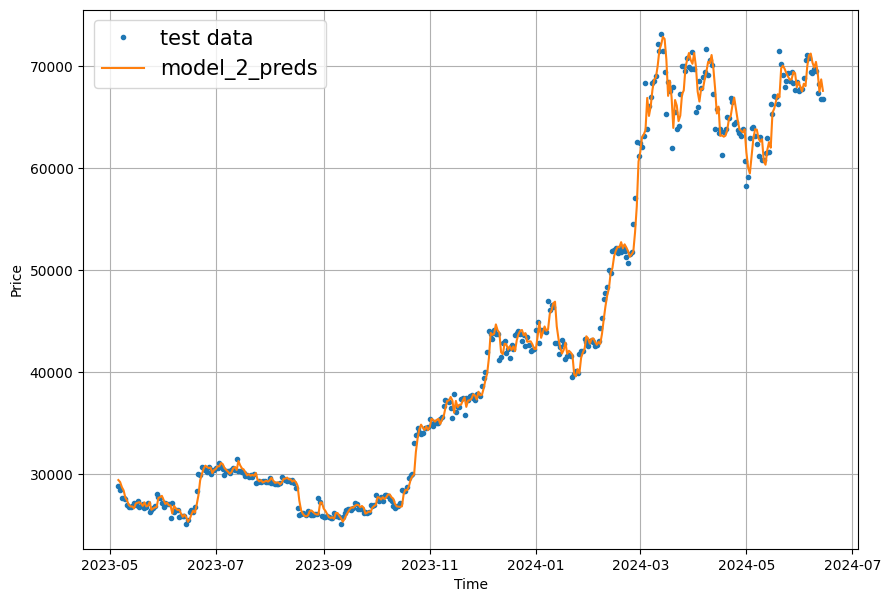

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows_2):],
                 values=test_labels_2[:, 0],
                 start=offset,
                 label="test data")

plot_time_series(timesteps=X_test[-len(test_windows_2):],
                 values=model_2_preds,
                 start=offset,
                 format="-",
                 label="model_2_preds")

Dense model with window = 30, horizon = 7

In [ ]:
HORIZON_3 = 7
WINDOW_SIZE_3 = 30

full_windows_3, full_labels_3 = make_windows(prices,
                                             window_size=WINDOW_SIZE_3,
                                             horizon=HORIZON_3)
len(full_windows_3), len(full_labels_3)

(3523, 3523)

In [ ]:
train_windows_3, test_windows_3, train_labels_3, test_labels_3 = make_train_test_splits(windows=full_windows_3,
                                                                                          labels=full_labels_3,
                                                                                          test_split=0.2)
len(train_windows_3), len(test_windows_3), len(train_labels_3), len(test_labels_3)

(2818, 705, 2818, 705)

In [ ]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON_3)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows_3,
            train_labels_3,
            batch_size=128,
            epochs=100,
            validation_data=(test_windows_3, test_labels_3),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
23/23 [==============================] - 1s 34ms/step - loss: 5019.7046 - val_loss: 4778.7119
Epoch 2/100
23/23 [==============================] - 1s 28ms/step - loss: 1636.5540 - val_loss: 3229.3000
Epoch 3/100
23/23 [==============================] - 1s 40ms/step - loss: 1551.3905 - val_loss: 2375.6270
Epoch 4/100
23/23 [==============================] - 0s 8ms/step - loss: 1265.2440 - val_loss: 2884.4814
Epoch 5/100
23/23 [==============================] - 1s 43ms/step - loss: 1260.5525 - val_loss: 2328.8618
Epoch 6/100
23/23 [==============================] - 1s 44ms/step - loss: 1104.6718 - val_loss: 1750.9817
Epoch 7/100
23/23 [==============================] - 0s 10ms/step - loss: 1034.7057 - val_loss: 2232.9253
Epoch 8/100
23/23 [==============================] - 0s 8ms/step - loss: 1198.8341 - val_loss: 2128.9561
Epoch 9/100
23/23 [==============================] - 0s 8ms/step - loss: 1114.3757 - val_loss: 1905.5435
Epoch 10/100
23/23 [=============================

In [ ]:
model_3.evaluate(test_windows_3, test_labels_3)

23/23 [==============================] - 0s 12ms/step - loss: 1457.5000


1457.5

In [ ]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows_3, test_labels_3)

23/23 [==============================] - 0s 5ms/step - loss: 1305.7346


1305.734619140625

In [ ]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows_3)
model_3_preds[:10]

23/23 [==============================] - 0s 6ms/step


<tf.Tensor: shape=(10, 7), dtype=float32, numpy=
array([[19161.975, 19200.082, 19506.754, 19836.283, 19894.586, 19248.004,
        19801.184],
       [19989.816, 19122.998, 19734.96 , 19648.123, 20883.28 , 20188.748,
        19210.441],
       [19350.379, 19291.748, 19764.188, 19751.074, 19767.955, 19788.65 ,
        20105.973],
       [20910.61 , 20662.363, 20425.656, 20432.717, 20725.264, 20568.604,
        21089.508],
       [20628.01 , 20515.312, 20756.832, 20817.914, 21640.773, 21001.414,
        20734.984],
       [21237.926, 21308.447, 20897.973, 21005.898, 21249.514, 21623.992,
        21099.54 ],
       [21325.447, 21765.232, 21005.146, 20675.412, 21584.193, 21512.133,
        20658.863],
       [20099.324, 21053.814, 20871.908, 19602.506, 20224.285, 20776.94 ,
        20388.078],
       [19707.627, 20141.785, 20174.027, 20078.943, 19782.8  , 20202.867,
        19803.012],
       [19769.844, 20253.174, 20210.844, 20067.344, 20117.605, 20523.996,
        19725.69 ]], dtype=floa

these results are multi-dimensional

In [ ]:
tf.squeeze(test_labels_3).shape, model_3_preds.shape

(TensorShape([705, 7]), TensorShape([705, 7]))

In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = MASE(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels_3),
                                 y_pred=model_3_preds)

model_3_results

{'mae': 1305.7345,
 'mse': 4019961.8,
 'rmse': 1506.0591,
 'mape': 3.857512,
 'mase': 2.1105294}

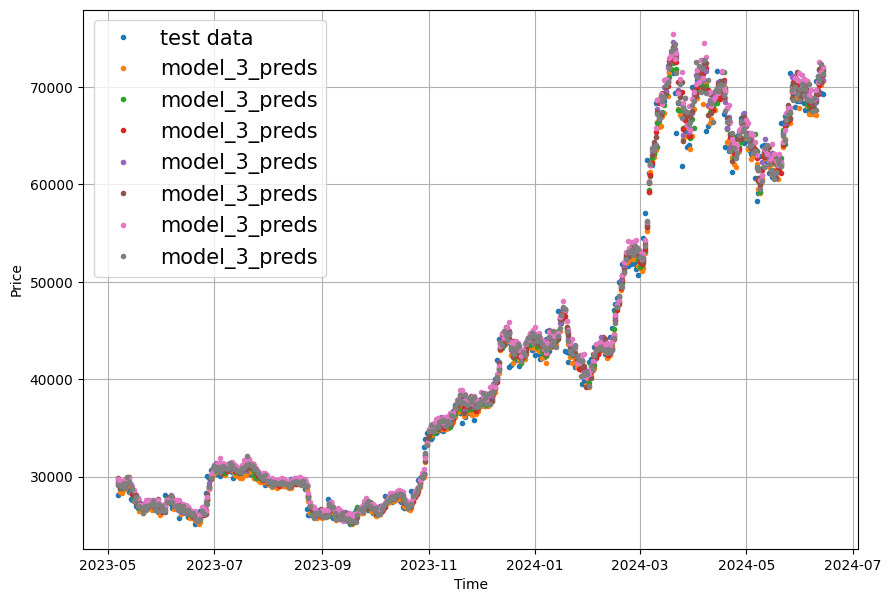

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows_3):],
                 values=test_labels_3[:, 0],
                 start=offset,
                 label="test data")

plot_time_series(timesteps=X_test[-len(test_windows_3):],
                 values=model_3_preds,
                 start=offset,
                 label="model_3_preds")

Looks very chaotic

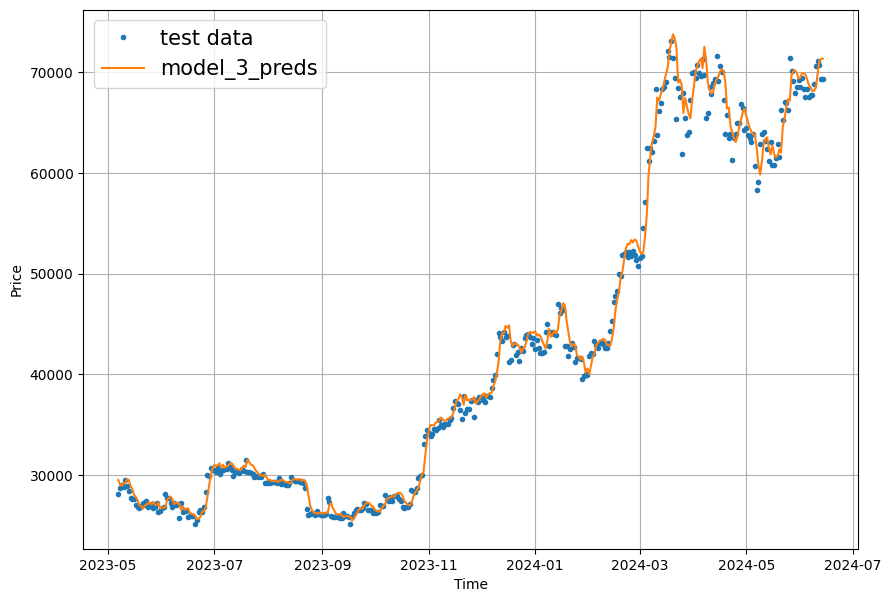

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows_3):],
                 values=test_labels_3[:, 0],
                 start=offset,
                 label="test data")

plot_time_series(timesteps=X_test[-len(test_windows_3):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label="model_3_preds")

Convolutional 1D model

In [ ]:
HORIZON_4 = 1
WINDOW_SIZE_4 = 7

In [ ]:
full_windows_4, full_labels_4 = make_windows(prices,
                                         window_size=WINDOW_SIZE_4,
                                         horizon=HORIZON_4)

len(full_windows_4), len(full_labels_4)

(3552, 3552)

In [ ]:
train_windows_4, test_windows_4, train_labels_4, test_labels_4 = make_train_test_splits(windows=full_windows_4,
                                                                                        labels=full_labels_4)
len(train_windows_4), len(test_windows_4), len(train_labels_4), len(test_labels_4)

(2841, 711, 2841, 711)

In [ ]:
# reshaping data

x = tf.constant(train_windows_4[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(x.shape)
print(expand_dims_layer(x).shape)

(7,)
(7, 1)


In [ ]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON_4)
], name="model_4_conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows_4,
            train_labels_4,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows_4, test_labels_4),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows_4, test_labels_4)

23/23 [==============================] - 0s 2ms/step - loss: 614.4109


614.4109497070312

In [ ]:
model_4_preds = make_preds(model_4, test_windows_4)

23/23 [==============================] - 0s 2ms/step


In [ ]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels_4),
                                 y_pred=model_4_preds)

model_4_results

{'mae': 614.41095,
 'mse': 1042756.75,
 'rmse': 1021.1546,
 'mape': 1.7668253,
 'mase': 0.9920455}

RNN model --> LSTM

Data used is same as the Conv1D model.


In [ ]:
HORIZON_5 = 1
WINDOW_SIZE_5 = 7

train_windows_5 = train_windows_4
train_labels_5 = train_labels_4
test_windows_5 = test_windows_4
test_labels_5 = test_labels_4

In [ ]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE_5))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON_5)(x)
model_5 = tf.keras.Model(inputs=inputs,
                         outputs=output,
                         name="model_5_lstm")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_5.fit(train_windows_5,
            train_labels_5,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows_5, test_labels_5),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
model_5_preds = make_preds(model_5, test_windows_5)

23/23 [==============================] - 1s 6ms/step


In [ ]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels_5),
                                 y_pred=model_5_preds)

model_5_results

{'mae': 628.7065,
 'mse': 1054544.2,
 'rmse': 1026.91,
 'mape': 1.8115819,
 'mase': 1.0151275}

Multivariate time series.

Bitcoin block reward size halves every four years or so.

In [ ]:
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [ ]:
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25
block_reward_5 = 3.125

block_reward_2_date = np.datetime64("2012-11-28")
block_reward_3_date = np.datetime64("2016-07-09")
block_reward_4_date = np.datetime64("2020-05-11")
block_reward_5_date = np.datetime64("2024-04-19")

In [ ]:
block_reward_2_days = (block_reward_3_date - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_date - bitcoin_prices.index[0]).days
block_reward_4_days = (block_reward_5_date - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days, block_reward_4_days

(661, 2063, 3502)

In [ ]:
# Multivariate data frame
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:block_reward_4_days, -1] = block_reward_4
bitcoin_prices_block.iloc[block_reward_4_days:, -1] = block_reward_5

In [ ]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-09-17,457.334015,25
2014-09-18,424.440002,25
2014-09-19,394.795990,25
2014-09-20,408.903992,25
2014-09-21,398.821014,25


In [ ]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2024-06-10,69512.281250,3.125
2024-06-11,67332.031250,3.125
2024-06-12,68241.187500,3.125
2024-06-13,66756.398438,3.125
2024-06-14,66703.804688,3.125


<Axes: xlabel='Date'>

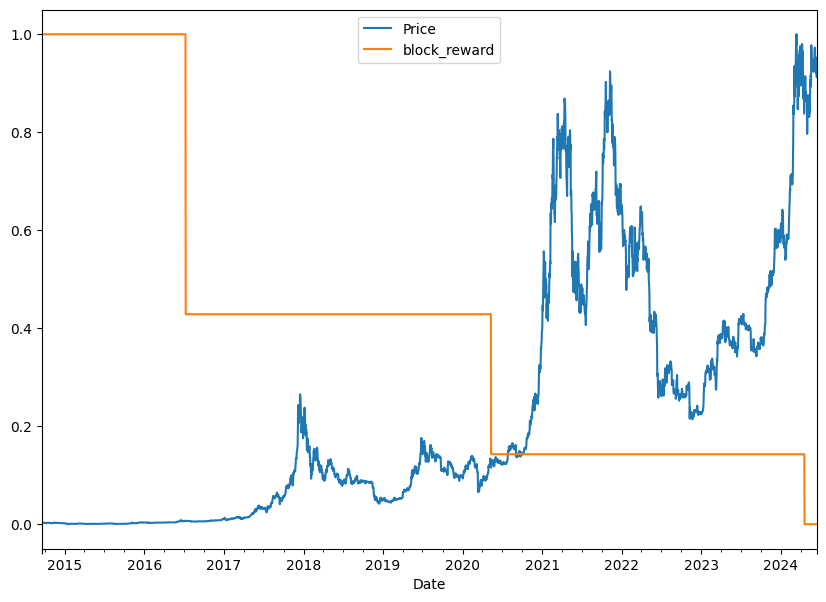

In [ ]:
# Plotting the data
from sklearn.preprocessing import minmax_scale

scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

As we can see, when the block reward goes down, the price goes up

In [ ]:
HORIZON_6 = 1
WINDOW_SIZE_6 = 7

In [ ]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE_6):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN


In [ ]:
# Preparing X and Y datasets
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

In [ ]:
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.0,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.0,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.0,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.0,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [ ]:
y.head()

Date
2014-09-24    423.204987
2014-09-25    411.574005
2014-09-26    404.424988
2014-09-27    399.519989
2014-09-28    377.181000
Name: Price, dtype: float32

In [ ]:
# Train and test splits
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2841, 2841, 711, 711)

In [ ]:
# Same as model 1
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON_6)
], name="model_6_dense_multivariate")

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
23/23 [==============================] - 3s 73ms/step - loss: 2758.3452 - val_loss: 2558.8521
Epoch 2/100
23/23 [==============================] - 1s 42ms/step - loss: 676.0748 - val_loss: 1193.7720
Epoch 3/100
23/23 [==============================] - 2s 69ms/step - loss: 520.8797 - val_loss: 723.8602
Epoch 4/100
23/23 [==============================] - 0s 6ms/step - loss: 418.8123 - val_loss: 789.6540
Epoch 5/100
23/23 [==============================] - 0s 7ms/step - loss: 418.7067 - val_loss: 964.4076
Epoch 6/100
23/23 [==============================] - 0s 7ms/step - loss: 416.2915 - val_loss: 778.8566
Epoch 7/100
23/23 [==============================] - 0s 7ms/step - loss: 423.6603 - val_loss: 726.9746
Epoch 8/100
23/23 [==============================] - 0s 6ms/step - loss: 416.8307 - val_loss: 863.6072
Epoch 9/100
23/23 [==============================] - 1s 39ms/step - loss: 410.9962 - val_loss: 691.7977
Epoch 10/100
23/23 [==============================] - 0s 6ms/step 

In [ ]:
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

23/23 [==============================] - 0s 3ms/step - loss: 611.9484


611.9484252929688

In [ ]:
model_6_preds = tf.squeeze(model_6.predict(X_test))

23/23 [==============================] - 0s 2ms/step


In [ ]:
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 611.9483,
 'mse': 1036574.5,
 'rmse': 1018.12305,
 'mape': 1.7464213,
 'mase': 0.98806924}

In [ ]:
model_1_results

{'mae': 614.72266,
 'mse': 1038270.56,
 'rmse': 1018.9556,
 'mape': 1.7609261,
 'mase': 0.9925488}

N-BEATS Algorithm

In [ ]:
# NBeats Block layer

class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)

    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
# Preparing the data
HORIZON_7 = 1
WINDOW_SIZE_7 = 7

bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE_7):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)

bitcoin_prices_nbeats.dropna(inplace=True)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,377.181000,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [ ]:
# X and y
X = bitcoin_prices_nbeats.drop("Price", axis=1)
y = bitcoin_prices_nbeats["Price"]

In [ ]:
# Split
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2841, 2841, 711, 711)

In [ ]:
# turning data to tf.data.Dataset
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

The following values are taken from the N-BEATS paper: https://arxiv.org/pdf/1905.10437


In [ ]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

# input size or lookback
INPUT_SIZE = WINDOW_SIZE_7 * HORIZON_7
THETA_SIZE = INPUT_SIZE + HORIZON_7

INPUT_SIZE, THETA_SIZE

(7, 8)

In [ ]:
tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON_7,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# First stack
backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name="subtrac_00")

for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                         theta_size=THETA_SIZE,
                                         horizon=HORIZON_7,
                                         n_neurons=N_NEURONS,
                                         n_layers=N_LAYERS,
                                         name=f"NBeatsBlock_{i}")(residuals)

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# Model
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_NBEATS")

model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

Epoch 1/5000
3/3 [==============================] - 56s 5s/step - loss: 73521.3672 - mae: 73521.3672 - mse: 10598839296.0000 - val_loss: 2046.4951 - val_mae: 2046.4951 - val_mse: 7281469.0000 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - 11s 3s/step - loss: 16488.3535 - mae: 16488.3555 - mse: 662142976.0000 - val_loss: 19370.3242 - val_mae: 19370.3242 - val_mse: 464481504.0000 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 11s 4s/step - loss: 11000.1807 - mae: 11000.1807 - mse: 461174144.0000 - val_loss: 11466.6992 - val_mae: 11466.6992 - val_mse: 162813504.0000 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 11s 3s/step - loss: 3646.2197 - mae: 3646.2197 - mse: 30118546.0000 - val_loss: 47341.6211 - val_mae: 47341.6211 - val_mse: 2776216576.0000 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 10s 4s/step - loss: 26246.4648 - mae: 26246.4648 - mse: 1536183296.0000 - val_loss: 2107.1179 - val_mae: 2107.1179 - val_mse

In [ ]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 1s 1s/step - loss: 611.2783 - mae: 611.2783 - mse: 1048677.5000


[611.2782592773438, 611.2782592773438, 1048677.5]

In [ ]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds

1/1 [==============================] - 3s 3s/step


<tf.Tensor: shape=(711,), dtype=float32, numpy=
array([20117.02 , 20142.062, 20471.57 , 21555.889, 21815.404, 21705.697,
       20802.848, 19958.223, 19408.668, 20230.594, 20509.154, 20618.7  ,
       21044.074, 20771.893, 22282.395, 23349.736, 23459.887, 23220.559,
       22526.69 , 22368.055, 22662.316, 21514.674, 21447.588, 22736.445,
       23475.754, 23771.65 , 23699.182, 23153.25 , 23190.508, 23079.762,
       22992.396, 22775.691, 23295.262, 23020.   , 23169.043, 23614.893,
       23135.7  , 23707.822, 23898.834, 24311.125, 24436.74 , 24230.625,
       24084.307, 23885.389, 23440.752, 23327.984, 21087.854, 21356.945,
       21438.26 , 21455.213, 21443.324, 21226.96 , 21529.447, 20384.086,
       20139.414, 19631.268, 20367.256, 19952.04 , 20004.402, 20108.164,
       19940.4  , 19859.578, 19974.826, 19851.852, 18961.242, 19278.951,
       19371.945, 20964.895, 21631.834, 21843.512, 22414.525, 20199.02 ,
       20146.115, 19680.623, 19947.727, 20068.43 , 19345.951, 19639.938,
   

In [ ]:
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)

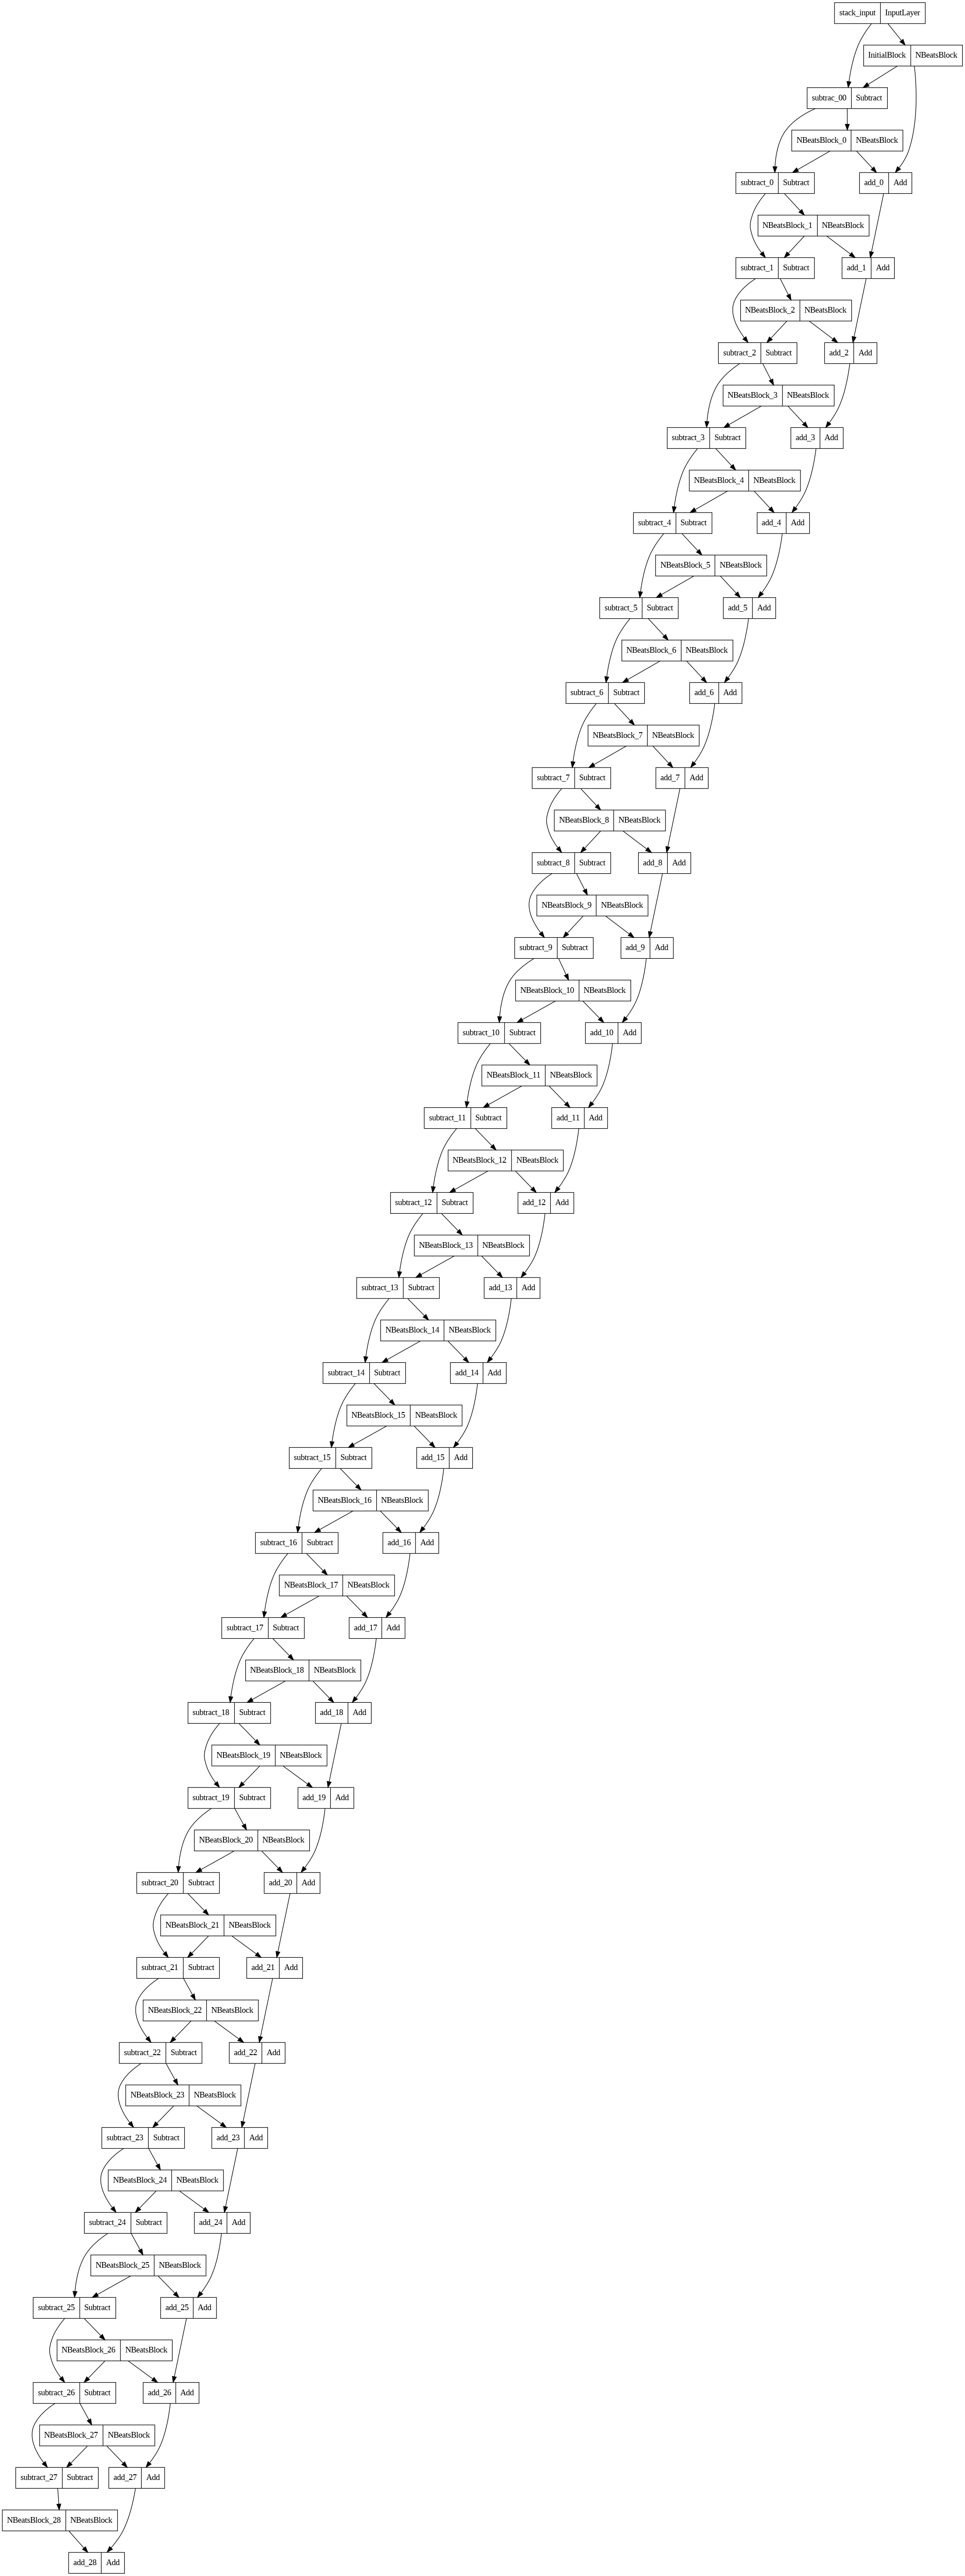

In [ ]:
# Plotting the model
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [ ]:
model_7.save(model_7.name)

Ensemble --> stacking different models using different loss functions

In [ ]:
def get_ensemble_models(horizon=HORIZON_7,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iterations=10,
                        num_epochs=1000,
                        loss_functions=["mae", "mse", "mape"]):
  ensemble_models = []

  for i in range(num_iterations):
    for loss_function in loss_functions:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model_number: {i}")

      # model
      model = tf.keras.Sequential([
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON_7)
      ])

      # Compile
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      ensemble_models.append(model)

    return ensemble_models

In [ ]:
ensemble_models = get_ensemble_models(num_iterations=5,
                                      num_epochs=1000)
# Results in 15 total models --> 5 for each loss function

Optimizing model by reducing: mae for 1000 epochs, model_number: 0
Optimizing model by reducing: mse for 1000 epochs, model_number: 0
Optimizing model by reducing: mape for 1000 epochs, model_number: 0

Epoch 218: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


In [ ]:
# Predictions:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)

ensemble_preds

1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 63ms/step


<tf.Tensor: shape=(3, 711), dtype=float32, numpy=
array([[20073.752, 19985.26 , 20456.264, ..., 67182.91 , 67917.72 ,
        66516.766],
       [20194.754, 20076.172, 20647.902, ..., 67427.37 , 68155.37 ,
        66811.15 ],
       [20180.951, 20177.24 , 20579.504, ..., 67484.21 , 68184.266,
        66767.53 ]], dtype=float32)>

In [ ]:
# Median of the ensemble models
y_preds=np.median(ensemble_preds, axis=0)

In [ ]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=y_preds)

ensemble_results

{'mae': 622.49536,
 'mse': 1061186.0,
 'rmse': 1030.1388,
 'mape': 1.7660049,
 'mase': 1.0050988}

Prediction intervals

In [ ]:
# Bootstrap method
def get_upper_lower_bounds(preds):
  std_dev = tf.math.reduce_std(preds, axis=0)

  interval = 1.96 * std_dev
  preds_mean = tf.reduce_mean(preds, axis=0)

  lower = preds_mean - interval
  upper = preds_mean + interval
  return lower, upper

In [ ]:
lower, upper = get_upper_lower_bounds(preds=ensemble_preds)

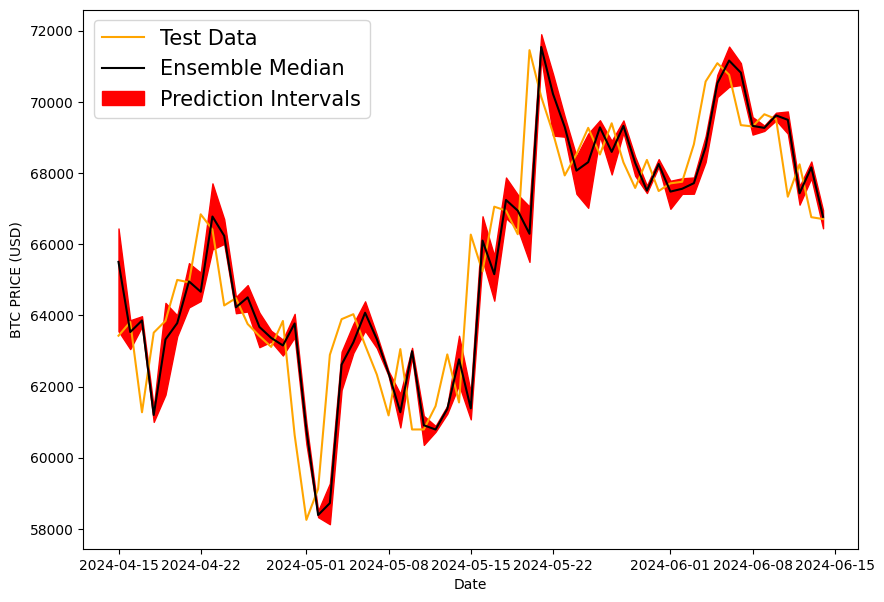

In [ ]:
# Plotting the results
ensemble_medians = np.median(ensemble_preds, axis=0)

offset=650
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "orange", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_medians[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC PRICE (USD)")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:],
                 label="Prediction Intervals",
                 color="red")
plt.legend(loc="upper left", fontsize=15)

Making a model on full historical data to make predictions into the future.

In [ ]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN


In [ ]:
# Training model on entire data
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [ ]:
# turning into tensorflow datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
# Model similar to model 1

model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON_7)
])

model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs=100)

Epoch 1/100
4/4 [==============================] - 2s 16ms/step - loss: 6747.4829
Epoch 2/100
4/4 [==============================] - 0s 21ms/step - loss: 1141.9501
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 2090.5884
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 856.8651
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 882.9326
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 1102.2294
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 705.6432
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 694.7882
Epoch 9/100
4/4 [==============================] - 0s 18ms/step - loss: 794.8256
Epoch 10/100
4/4 [==============================] - 0s 35ms/step - loss: 757.0696
Epoch 11/100
4/4 [==============================] - 0s 15ms/step - loss: 703.9169
Epoch 12/100
4/4 [==============================] - 0s 14ms/step - loss: 656.5539
Epoch 13/100
4/4 [===

In [ ]:
# Making predictions

IN_FUTURE = 15
# 15 days to predict into the future

In [ ]:
def make_future_forecast(values, model, in_future, window_size=WINDOW_SIZE_7) -> list:
  future_forecast = []
  last_window = values[-window_size:]

  for i in range(in_future):
    future_prediction = model.predict(tf.expand_dims(last_window, axis=0))
    future_forecast.append(tf.squeeze(future_prediction).numpy())

    last_window = np.append(last_window, future_prediction)[-window_size:]

  return future_forecast

In [ ]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       in_future=IN_FUTURE,
                                       window_size=WINDOW_SIZE_7)

1/1 [==============================] - 0s 28ms/step


In [ ]:
future_forecast

[68803.195,
 69070.3,
 68054.625,
 67284.75,
 67533.62,
 66754.96,
 67245.125,
 68334.164,
 68188.98,
 67311.73,
 67078.266,
 67081.94,
 66797.71,
 67274.64,
 67773.02]

In [ ]:
# Plotting this
def get_future_dates(start_date, in_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(in_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [ ]:
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2024-06-14 00:00:00')

In [ ]:
# next 15 days of timestamps
next_time_stamps = get_future_dates(start_date=last_timestep,
                                    in_future=IN_FUTURE)
next_time_stamps

array(['2024-06-15', '2024-06-16', '2024-06-17', '2024-06-18',
       '2024-06-19', '2024-06-20', '2024-06-21', '2024-06-22',
       '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26',
       '2024-06-27', '2024-06-28', '2024-06-29'], dtype='datetime64[D]')

In [ ]:
# Inserting last timestep
next_time_stamps = np.insert(next_time_stamps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, bitcoin_prices[-1:])
next_time_stamps, future_forecast

(array(['2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17',
        '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21',
        '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25',
        '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29'],
       dtype='datetime64[D]'),
 array([66703.805, 68803.195, 69070.3  , 68054.625, 67284.75 , 67533.62 ,
        66754.96 , 67245.125, 68334.164, 68188.98 , 67311.73 , 67078.266,
        67081.94 , 66797.71 , 67274.64 , 67773.02 ], dtype=float32))

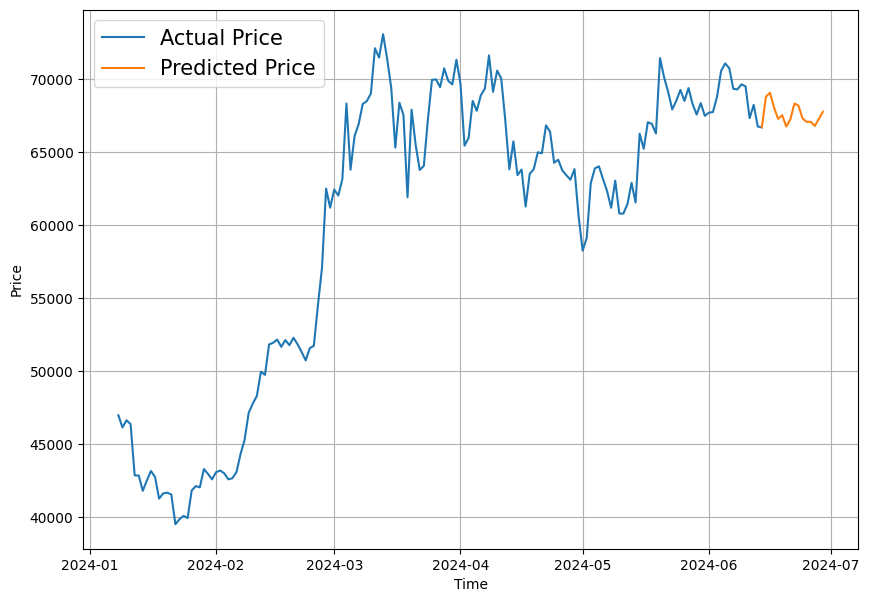

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, np.squeeze(bitcoin_prices.to_numpy()), start=3400, format="-", label="Actual Price")
plot_time_series(next_time_stamps, future_forecast, format="-", label="Predicted Price")

Turkey Problem

In [ ]:
# introducing a turkey problem data point to our data
btc_price_turkey = np.squeeze(bitcoin_prices.to_numpy())
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
btc_price_turkey[-10:]

array([71082.820313  , 70757.164063  , 69342.585938  , 69305.773438  ,
       69647.992188  , 69512.28125   , 67332.03125   , 68241.1875    ,
       66756.398438  ,   667.03804688])

In [ ]:
btc_timesteps = np.array(bitcoin_prices.index)
btc_timesteps[-10:]

array(['2024-06-05T00:00:00.000000000', '2024-06-06T00:00:00.000000000',
       '2024-06-07T00:00:00.000000000', '2024-06-08T00:00:00.000000000',
       '2024-06-09T00:00:00.000000000', '2024-06-10T00:00:00.000000000',
       '2024-06-11T00:00:00.000000000', '2024-06-12T00:00:00.000000000',
       '2024-06-13T00:00:00.000000000', '2024-06-14T00:00:00.000000000'],
      dtype='datetime64[ns]')

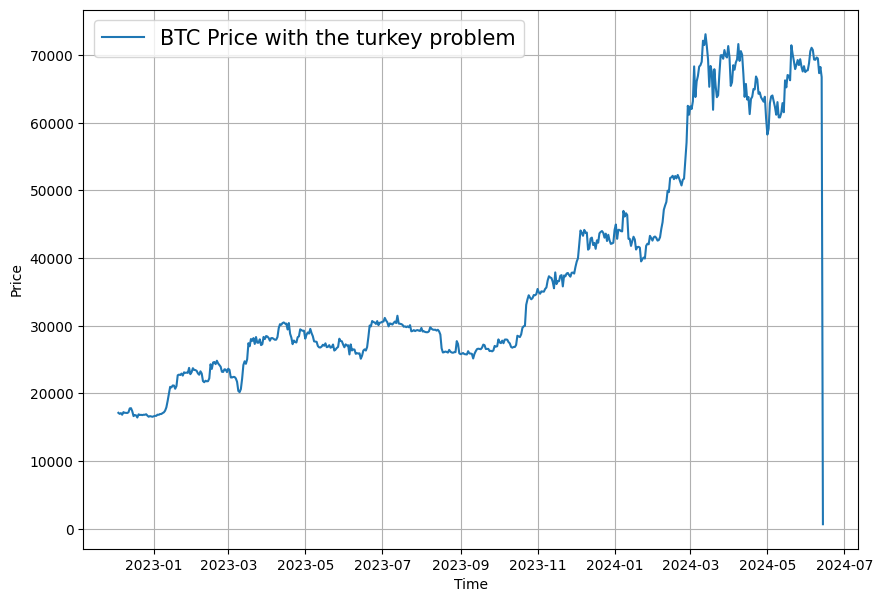

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=btc_timesteps,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price with the turkey problem",
                 start = 3000)

In [ ]:
full_windows_10, full_labels_10 = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE_7, horizon=HORIZON_7)
len(full_windows_10), len(full_labels_10)

(3552, 3552)

In [ ]:
X_train_10, X_test_10, y_train_10, y_test_10 = make_train_test_splits(full_windows_10, full_labels_10)
len(X_train_10), len(X_test_10), len(y_train_10), len(y_test_10)

(2841, 711, 2841, 711)

In [ ]:
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())

turkey_model.fit(X_train_10, y_train_10,
                 epochs=100,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

Epoch 1/100
89/89 [==============================] - 3s 21ms/step - loss: 2543.2229 - val_loss: 1405.6282
Epoch 2/100
89/89 [==============================] - 1s 14ms/step - loss: 663.6472 - val_loss: 1219.1970
Epoch 3/100
89/89 [==============================] - 0s 4ms/step - loss: 623.6938 - val_loss: 1293.9324
Epoch 4/100
89/89 [==============================] - 1s 8ms/step - loss: 552.3607 - val_loss: 1615.1934
Epoch 5/100
89/89 [==============================] - 1s 6ms/step - loss: 505.4657 - val_loss: 1516.1371
Epoch 6/100
89/89 [==============================] - 1s 7ms/step - loss: 461.1607 - val_loss: 1836.2377
Epoch 7/100
89/89 [==============================] - 1s 7ms/step - loss: 455.2755 - val_loss: 1749.3810
Epoch 8/100
89/89 [==============================] - 1s 6ms/step - loss: 475.0033 - val_loss: 2252.7700
Epoch 9/100
89/89 [==============================] - 1s 8ms/step - loss: 462.3831 - val_loss: 1870.7611
Epoch 10/100
89/89 [==============================] - 0s 3ms/

In [ ]:
turkey_model.evaluate(X_test_10, y_test_10)

23/23 [==============================] - 0s 3ms/step - loss: 720.7189


720.7188720703125

In [ ]:
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test_10, y_test_10)

In [ ]:
turkey_preds = make_preds(turkey_model, X_test_10)
turkey_preds

23/23 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(711,), dtype=float32, numpy=
array([19904.084, 19841.883, 20050.066, 20435.318, 20838.611, 21232.08 ,
       21219.775, 21199.197, 20989.2  , 20856.514, 20582.188, 20510.033,
       20549.068, 20656.414, 21358.281, 21792.086, 22285.537, 22578.287,
       22789.37 , 23138.701, 23150.059, 22719.656, 22474.547, 22471.38 ,
       22678.184, 22896.957, 22995.373, 23319.5  , 23725.555, 23690.658,
       23545.129, 23315.816, 23335.775, 23193.5  , 23250.24 , 23349.959,
       23372.734, 23700.988, 23680.33 , 24067.307, 24163.59 , 24280.746,
       24415.26 , 24400.844, 24276.545, 24099.73 , 23331.422, 23013.867,
       22448.768, 22155.719, 21761.682, 21473.371, 21675.01 , 21389.04 ,
       21237.342, 20841.367, 20811.246, 20376.795, 20244.475, 20138.066,
       20185.645, 20195.344, 20151.19 , 20144.98 , 19893.066, 19827.252,
       19665.42 , 20123.25 , 20205.45 , 20673.848, 21175.44 , 21206.572,
       21540.234, 21062.76 , 20960.098, 20546.316, 20050.08 , 20010.605,
   

In [ ]:
turkey_results = evaluate_preds(y_true=y_test_10,
                                y_pred=turkey_preds)
turkey_results

{'mae': 16850.0,
 'mse': 519054800.0,
 'rmse': 21764.154,
 'mape': 60.712986,
 'mase': 23.654203}

In [ ]:
model_1_results

{'mae': 614.72266,
 'mse': 1038270.56,
 'rmse': 1018.9556,
 'mape': 1.7609261,
 'mase': 0.9925488}

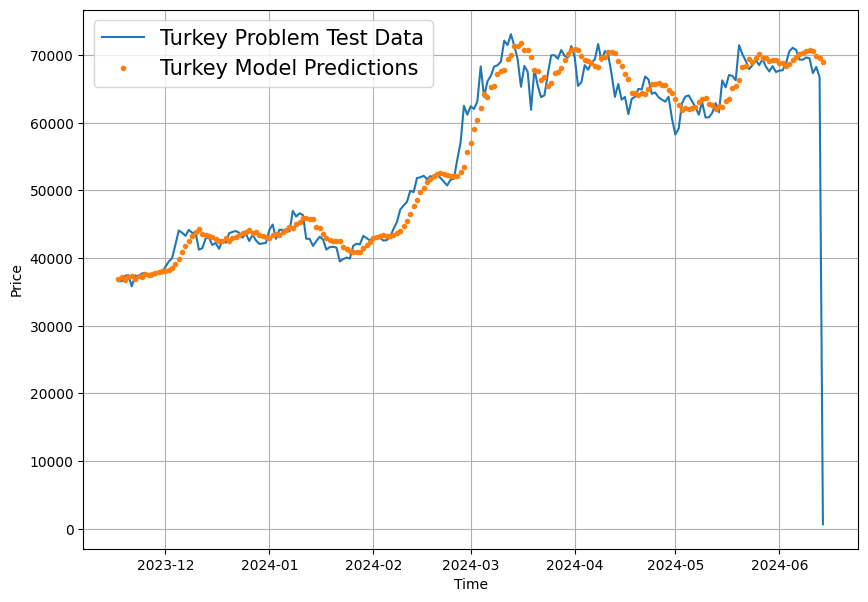

In [ ]:
# plotting this for better visualization
plt.figure(figsize=(10, 7))

offset = 500
plot_time_series(timesteps=btc_timesteps[-len(X_test_10):],
                 values=btc_price_turkey[-len(y_test_10):],
                 format="-",
                 label="Turkey Problem Test Data",
                 start=offset)

plot_time_series(timesteps=btc_timesteps[-len(X_test_10):],
                 values=turkey_preds,
                 label="Turkey Model Predictions",
                 start=offset)

Comparing Models

In [ ]:
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense": model_1_results,
                              "model_2_dense": model_2_results,
                              "model_3_dense": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "turkey_model": turkey_results
                              }).T

model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,618.524231,1.057174e+06,1028.189575,1.754393,0.998687
model_1_dense,614.722656,1.038271e+06,1018.955627,1.760926,0.992549
model_2_dense,651.940308,1.073149e+06,1035.928833,1.891361,1.050993
model_3_dense,1305.734497,4.019962e+06,1506.059082,3.857512,2.110529
model_4_CONV1D,614.410950,1.042757e+06,1021.154602,1.766825,0.992046
model_5_LSTM,628.706482,1.054544e+06,1026.910034,1.811582,1.015128
model_6_multivariate,611.948303,1.036574e+06,1018.123047,1.746421,0.988069
model_7_NBEATS,611.278259,1.048678e+06,1024.049561,1.744485,0.986987
model_8_ensemble,622.495361,1.061186e+06,1030.138794,1.766005,1.005099
turkey_model,16850.000000,5.190548e+08,21764.154297,60.712986,23.654203


<Axes: >

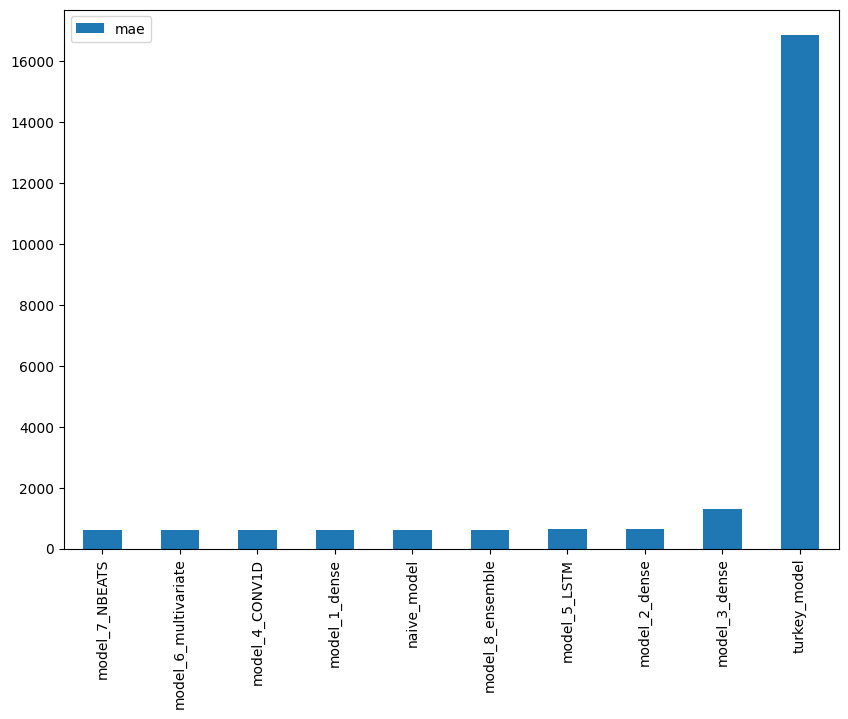

In [ ]:
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar")